In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload
import wrangle as w
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.cluster import KMeans

In [31]:
reload(w)
df = w.wrangle_zillow(prop_row=.75,prop_col=.5)


In [32]:
train, validate, test = w.tvt_split(df)

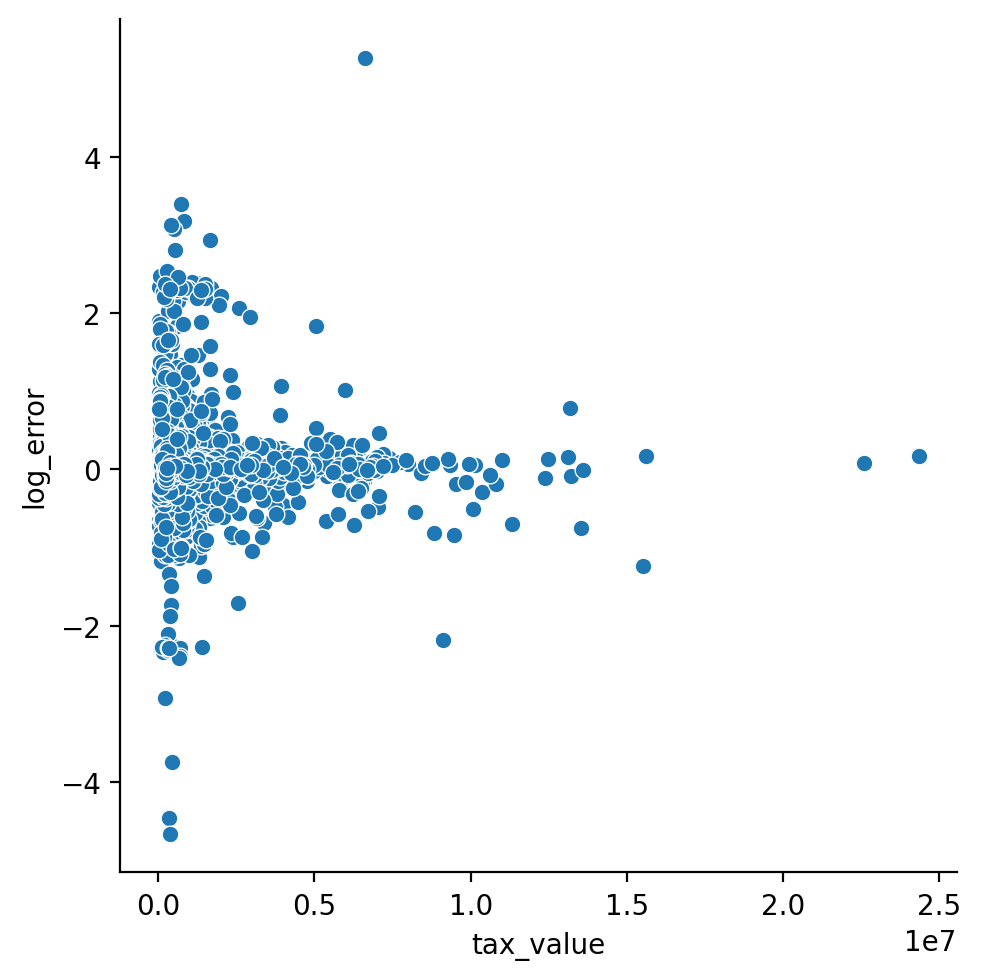

In [34]:

sns.relplot(data=train, x='tax_value', y='log_error')

In [35]:
train.columns

Index(['parcel_id', 'bath_count', 'bed_count', 'calc_bath_and_bed',
       'calc_sqft', 'finished_sqft12', 'fips', 'fireplace_cnt',
       'full_bath_cnt', 'garage_car_count', 'latitude', 'longitude',
       'lot_sqft', 'pool_count', 'property_county_use_code',
       'property_zoning_desc', 'raw_census_tract_block', 'region_id_city',
       'region_id_county', 'region_id_zip', 'room_count', 'unit_count',
       'year_built', 'structure_tax_value', 'tax_value', 'assessment_year',
       'land_value', 'tax_amount', 'census_tract_and_block', 'log_error',
       'transaction_date', 'heating_system_desc', 'property_land_use_desc',
       'outliers'],
      dtype='object')

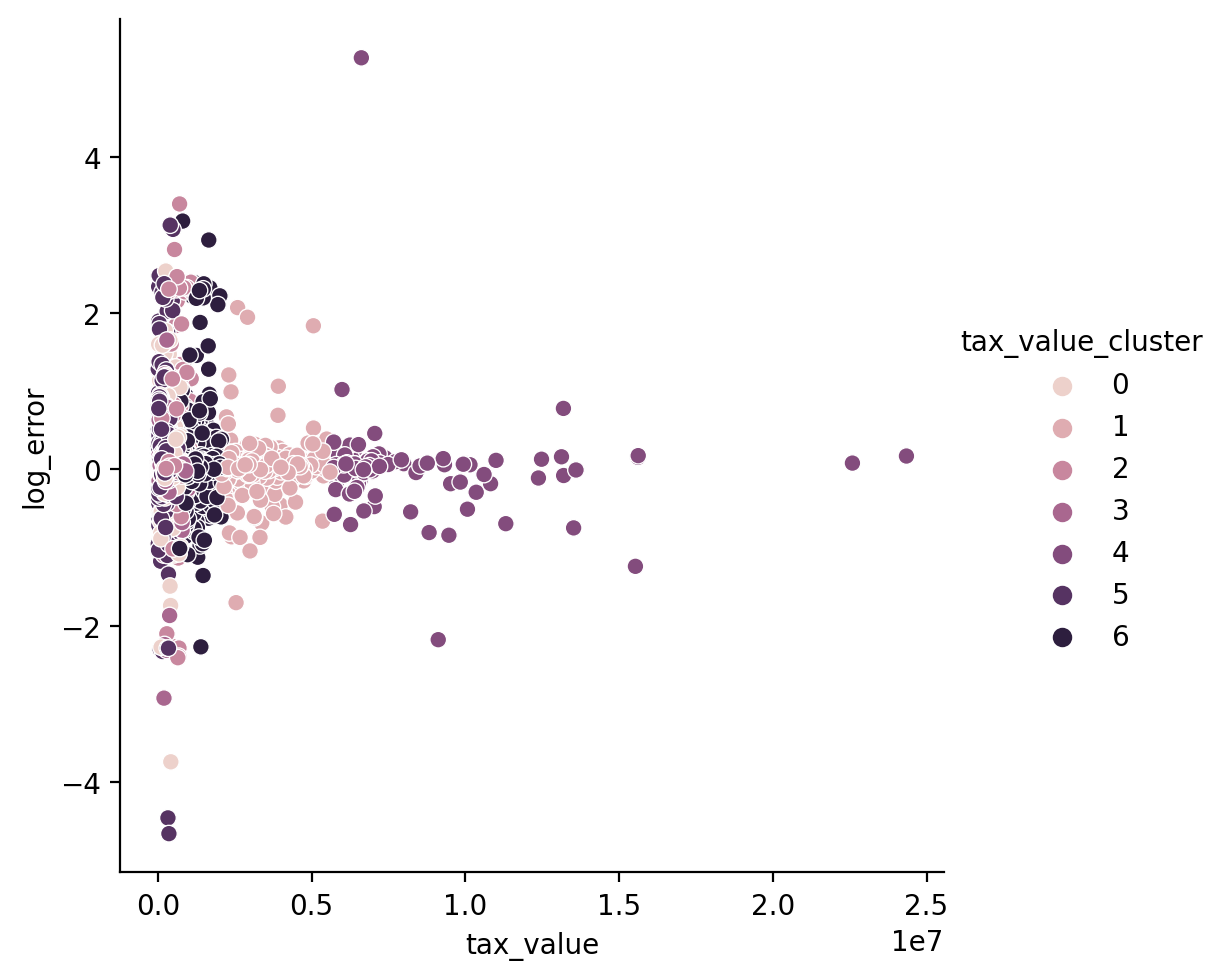

In [38]:
kmeans = KMeans(7)
cluster_by = ['tax_value','latitude','longitude']
kmeans.fit(train[cluster_by])
train['tax_value_cluster'] = kmeans.predict(train[cluster_by])
sns.relplot(data=train, x='tax_value',y='log_error',hue='tax_value_cluster',palette='')

In [39]:
train.tax_value_cluster.value_counts()

5    15530
0    11239
2     8295
6     3968
3     3502
1      689
4       97
Name: tax_value_cluster, dtype: int64